# Moguls of Chaos

This example was taken from the book **The Essence of Chaos** by *Edward Lorenz*. The aim of the model he presented in that chapter is to show how we can construct parsimonious models from real case phenomena which exhibit chaos. 

The model consists of a board that goes down a regularly-bumpy slope or moguls without any control of the direction whatsoever. The dynamical system of this board is described by the system of ODE shown bellow

$$\frac{dx}{dt} = U, \quad \frac{dx}{dt} = V, \quad \frac{dz}{dt} = W.$$

\begin{align}
\frac{du}{dt} &= -F \partial_x H - cu, \\
\frac{dv}{dt} &= -F \partial_y H - cv, \\
\frac{dw}{dt} &= -g + F - cw.
\end{align}

$\vec{x} = (x,y,z)$ are the spacial coordinates and $\vec{u} = (u,v,w)$ are the components of the velocity of the board. And $H$ is the shape pf the slope that is parameterized by the following expression: 

$$H(x,y) = -ax - b \ cos(px) \ cos(qy).$$

$a$ is the angle of the slope, $b$ is the height of the bumps, and $q$ and $p$ are spacial frequencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

%matplotlib inline

We can plot the shape of the moguls to help us understand better the problem. For this we use the parameters that Lorenz suggest in his book, in which $a$ is the angle of the slope, $b$ is the depth of the moguls, and $p$ and $q$ are the spatial frequencies of the moguls in the $x$ and $y$ directions. 

In [2]:
a = 0.25
b = 0.4
q = (2 * pi) / 4.0
p = (2 * pi) / 10.0


def H_func(x, y):
    """
        H_func(x,y)
    Function that parametrizes the moguls. 
    It takes a given x and y position as arguments, and returns 
    the height of the slope.
    """
    return -a * x - b * np.cos(p * x) * np.cos(q * y)


def pits_n_crests(x, y):
    """
        pits_n_crests(x,y)
        
    Function that parametrizes the moguls without the slope. 
    It takes a given x and y position as arguments, and returns 
    the heights of the moguls as if they were in a flat surface.
    """
    return -b * np.cos(p * x) * np.cos(q * y)

In [3]:
x_range = np.linspace(0, 20, 200)
y_range = np.linspace(-10, 10, 200)
XX, YY = np.meshgrid(x_range, y_range)
moguls = H_func(XX, YY)

In [4]:
from mpl_toolkits.mplot3d import Axes3D

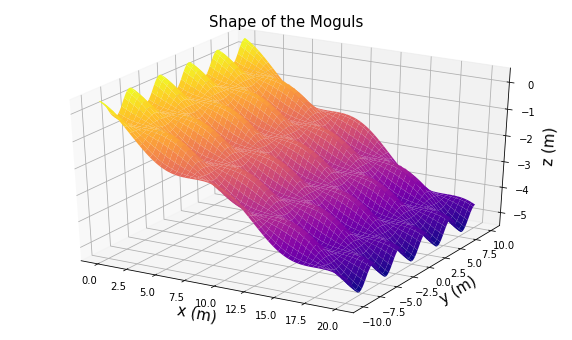

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection="3d")

ax.set_ylabel("y (m)", fontsize=15)
ax.set_xlabel("x (m)", fontsize=15)
ax.set_zlabel("z (m)", fontsize=15)
ax.set_title("Shape of the Moguls", fontsize=15)

ax.plot_surface(XX, YY, moguls, cmap="plasma")
plt.savefig("fig/shape_of_moguls")

**Quite cool so far!** I ❤ matplotlib.

# Boards down the slope!

Our first goal is to solve the ODE system for a given initial condition using a numerical integration method. For this, we declare a function containing the right-hand side terms of the ODE system that we want to solve. 

In [6]:
def board(t, X_0):
    """
        board(t, X_0)

    Right-hand-side of the equations for a board going down a slope with moguls.

    X_0 is the the set of initial conditions containing [x, y, u, v], in that oder.
    t optional parameter.
    """

    x0 = X_0[0]
    y0 = X_0[1]
    u0 = X_0[2]
    v0 = X_0[3]

    g = 9.81
    c = 0.5
    a = 0.25
    b = 0.5
    p = (2 * pi) / 10.0
    q = (2 * pi) / 4.0

    H = -a * x0 - b * cos(p * x0) * cos(q * y0)
    H_x = -a + b * p * sin(p * x0) * cos(q * y0)
    H_xx = b * p ** 2 * cos(p * x0) * cos(q * y0)
    H_y = b * q * cos(p * x0) * sin(q * y0)
    H_yy = b * q ** 2 * cos(p * x0) * cos(q * y0)
    H_xy = -b * q * p * sin(p * x0) * sin(q * y0)

    F = (g + H_xx * u0 ** 2 + 2 * H_xy * u0 * v0 + H_yy * v0 ** 2) / (
        1 + H_x ** 2 + H_y ** 2
    )

    dU = -F * H_x - c * u0
    dV = -F * H_y - c * v0

    return np.array([u0, v0, dU, dV])

We use the fourth-order **Runge-Kutta method** as an integrator and we wrap it around the `solver` function. 

In [7]:
def runge_kutta_step(f, x0, dt, t=None):
    """
        runge_kutta_step(f, x0, dt, t=None)

    Computes a step using the Runge-Kutta 4th order method.

    f is a RHS function, x0 is an array of variables to solve, 
    dt is the timestep, and t correspond to an extra paramameter of
    of the RHS.
    """

    k1 = f(t, x0) * dt
    k2 = f(t, x0 + k1 / 2) * dt
    k3 = f(t, x0 + k2 / 2) * dt
    k4 = f(t, x0 + k3) * dt
    x_new = x0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return x_new


def solver(f, x0, y0, v0, u0, dt, N_t, N, b=0.5):
    """
        solver(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5)

    Function iterate the solution using runge_kutta_step and a RHS function f, for several points or initial 
    conditions given by N.

    f is a RHS function
    x0, y0, v0, u0 are arrays containig the initial condition x,y,v,u; with N dimensions.
    dt is the timestep, 
    N_t number of time steps.
    N number of initial conditions to iterate.
    b height of the moguls, parameter fixed.
    """

    solution = np.zeros((4, N_t + 1, N))
    solution[0, 0, :] = x0
    solution[1, 0, :] = y0
    solution[2, 0, :] = u0
    solution[3, 0, :] = v0

    for i in range(1, N_t + 1):
        for k in range(N):

            x_0_step = solution[:, i - 1, k]
            solution[:, i, k] = runge_kutta_step(f, x_0_step, dt, b)

    return solution

In [8]:
def plot_several(Solution):
    """
        plot_several_position(Solution)

    Function to plot several trajectories of boards or sleds. 
    Solution is the array with the solutions of the ensemble of points.
    """

    N = Solution.shape[2]
    plt.figure(figsize=(5, 10))

    for i in range(0, N):
        plt.plot(Solution[1, :, i], Solution[0, :, i])

    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid()
    plt.ylabel("x - Downslope position (m)", fontsize=13)
    plt.xlabel("y - Crossslope position (m)", fontsize=13)

So now that we have our solver we can crush some snow with our boards in the moguls! 

### Example 1

Initial conditions: $x = 0.0$, $y = [0,1]$ (randomly chosen), $U = 3.5$ and $V = 0$.

Text(0.5, 1.0, '10 boards')

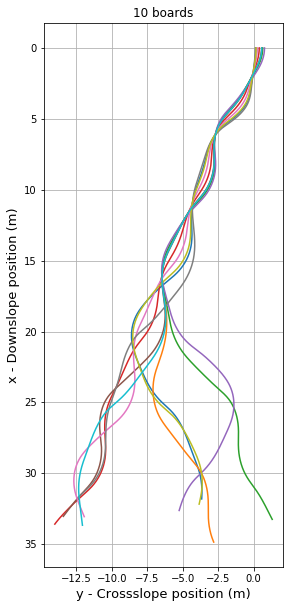

In [9]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds)
v_init = np.zeros(n_sleds)
u_init = np.zeros(n_sleds) + 3.5

sol_ex1 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds)

plot_several(sol_ex1)
plt.title("10 boards")

### Example 2

Initial conditions: $x = 0.0$, $y = [0,1]$ scattered evenly, $U = 4.0$ and $V = 2.0$.

Text(0.5, 1.0, '1 cm between boards')

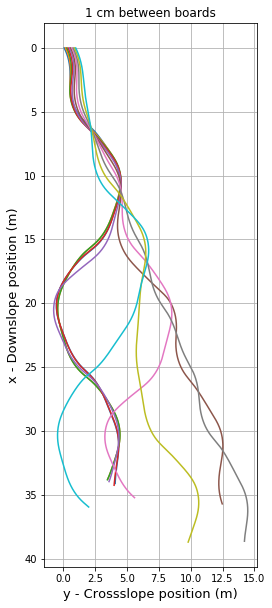

In [10]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.1, 1, n_sleds)
v_init = np.zeros(n_sleds) + 2
u_init = np.zeros(n_sleds) + 4

sol_ex2 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds)

plot_several(sol_ex2)
plt.title("1 cm between boards")

We can see how the system behaves chaotically, i.e if we vary a little the initial conditions, the trajectories of the boards diverge after 10 m downslope.

### Example 3
Initial conditions just spaced $1$mm apart from $0.497$m to $0.503$m.

Text(0.5, 1.0, '1 mm between boards')

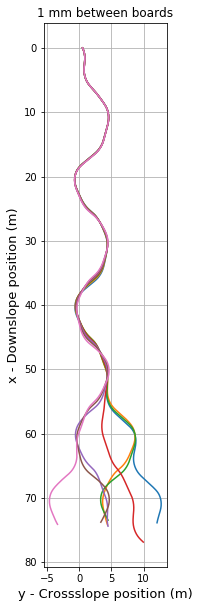

In [11]:
n_sleds = 7
n_time = 2200
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.497, 0.503, n_sleds)
v_init = np.zeros(n_sleds) + 2
u_init = np.zeros(n_sleds) + 4

sol_ex3 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds)

plot_several(sol_ex3)
plt.title("1 mm between boards")

The above shows that the system is sensitive to initial conditions but we would like to explore further the dynamics of the system. One of the technique for exploring the dynamics of the system is by plotting the phase space and see how the system behaves. The only problem is that for this system, there are 4 variables, which means that the phase space of the system lives in a four-dimensional space, which is not possible for us to visualize. We need to do some modifications to our board to reduce the dimensions of our system.


# Sleds down the slope!

To reduce the dimensions of our system, we can make the downslope velocity to be constants, or in the real world, by equipping our board with some brakes and an engine so it can maintain a constant velocity while going down the pits or up the bumps. In a mathematical sense, we say that $\partial_t U = 0$.

In [12]:
def sled(t, X_0):
    """
        sled(t, X_0)

    Right-hand-side of the equations for a sled, with constant downward velocity, 
    going down a slope with moguls.

    X_0 is the the set of initial conditions containing [x, y, u, v], in that oder.
    t optional parameter.
    """

    x0 = X_0[0]
    y0 = X_0[1]
    u0 = X_0[2]
    v0 = X_0[3]

    g = 9.81
    c = 0.5
    a = 0.25
    # b = 0.5
    p = (2 * pi) / 10.0
    q = (2 * pi) / 4.0

    H = -a * x0 - b * cos(p * x0) * cos(q * y0)
    H_x = -a + b * p * sin(p * x0) * cos(q * y0)
    H_xx = b * p ** 2 * cos(p * x0) * cos(q * y0)
    H_y = b * q * cos(p * x0) * sin(q * y0)
    H_yy = b * q ** 2 * cos(p * x0) * cos(q * y0)
    H_xy = -b * q * p * sin(p * x0) * sin(q * y0)

    F = (g + H_xx * u0 ** 2 + 2 * H_xy * u0 * v0 + H_yy * v0 ** 2) / (
        1 + H_x ** 2 + H_y ** 2
    )

    dU = 0
    dV = -F * H_y - c * v0

    return np.array([u0, v0, dU, dV])

Let's try it.

Initial conditions $x = 0$ m, $y = [0.1, 1]$ m, $v = 0$ m/s and $u = 3.5$ m/s.

Text(0.5, 1.0, '10 sleds down the slope')

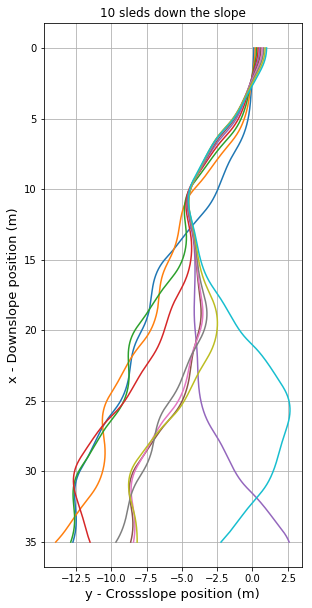

In [13]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.1, 1, n_sleds)
u_init = np.zeros(n_sleds) + 3.5
v_init = np.zeros(n_sleds)

sled_ex1 = solver(sled, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds)

plot_several(sled_ex1)
plt.title("10 sleds down the slope")

We see that the system behaves chaotically even though the downslope speed is maintained. 

# Sleds and strange attractors

Now our system has 3 variables, which will allow us to plot it phase space. The only problem now is that the system is no compact, because $x$ and $y$ can grow or decrease infinitively. Although, the cross slope velocity $v$ is bounded between $-5$ m/s and $5$ m/s, because of friction.

A way to do this is reducing the slope to be $x \in [-5, 5]$ m and $y \in [-2, 2]$ m, and set the boundaries to be periodic. This way, we will be able to compact the position of the sled without altering the physics of the system. 

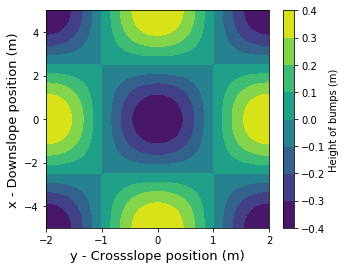

In [14]:
x_range_compact = np.linspace(-5, 5, 50)
y_range_compact = np.linspace(-2, 2, 50)
XX_c, YY_c = np.meshgrid(x_range_compact, y_range_compact)

moguls_compact = pits_n_crests(XX_c, YY_c)

plt.figure(figsize=(5, 4))
plt.contourf(YY_c, XX_c, moguls_compact)
plt.colorbar(label="Height of bumps (m)")
plt.ylabel("x - Downslope position (m)", fontsize=13)
plt.xlabel("y - Crossslope position (m)", fontsize=13)
plt.savefig("fig/shape_of_moguls_compact")

In [15]:
def compactor(x, lower_bound, upper_bound):
    """
        compactor(x, lower_bound, upper_bound)

    Funtion that maps any point outside the interval [lower_bound, upper_bound] 
    to a point in the interval, preserving length. If the point is in the interval,
    it does not change.

    x point in question to be evaluated.
    lower_bound lower bound of the interval.
    upper_bound upper bound of the interval.
    """

    if x > upper_bound:
        return x % upper_bound - upper_bound
    elif x < lower_bound:
        return x % lower_bound - lower_bound
    else:
        return x

In [16]:
def solver_compact(f, x0, y0, v0, u0, dt, N_t, N, b=0.5):
    """
        solver_compact(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5)

    Function iterate the solution using runge_kutta_step and a RHS function f, for several points or initial 
    conditions given by N, in compact domain. 

    f is a RHS function
    x0, y0, v0, u0 are arrays containig the initial condition x,y,v,u; with N dimensions.
    dt is the timestep, 
    N_t number of time steps.
    N number of initial conditions to iterate.
    b height of the moguls, parameter fixed.
    """

    solution = np.zeros((3, N_t + 1, N))
    solution[0, 0, :] = x0
    solution[1, 0, :] = y0
    solution[2, 0, :] = v0

    for i in range(1, N_t + 1):
        for k in range(N):

            x_0_step = np.insert(solution[:, i - 1, k], 2, u0)

            aux = runge_kutta_step(f, x_0_step, dt, b)
            solution[0, i, k] = compactor(aux[0], -5, 5)
            solution[1, i, k] = compactor(aux[1], -2, 2)
            solution[2, i, k] = aux[3]

    return solution

Let's try it!

Text(0.5, 1.0, '1 sled in compact domain')

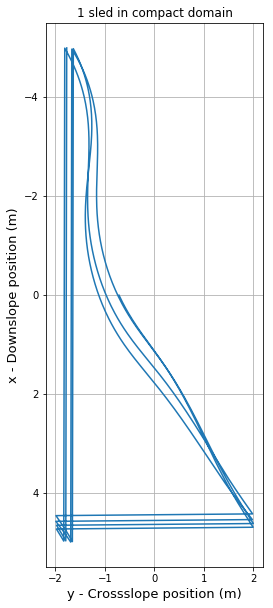

In [17]:
n_sleds = 1
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds) * 4 - 2
v_init = np.random.rand(n_sleds) * 10 - 5

sled_compact_1 = solver_compact(
    sled, x_init, y_init, 3.5, v_init, 0.01, n_time, n_sleds
)
plot_several(sled_compact_1)

plt.title("1 sled in compact domain")

We can see how the sled goes out of the domain and re-enters at the opposite side. 

The main interest of this is to build a strange attractor. For this, we set a ensemble of sled all starting from $x = 0$ m, but with random $y$ and cross slope velocities $v$, and with $u$ set to 3.5 m.

In [18]:
import time

In [19]:
n_sleds = 1000
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds) * 4 - 2
v_init = np.random.rand(n_sleds) * 10 - 5

start = time.time()
sled_compact_1000 = solver_compact(
    sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds
)
end = time.time()
print("Elapsed time:", (end - start) / 60, "minutes...")

KeyboardInterrupt: 

> Here is when I realized how bad I am in making my code to go fast... 

Once that we have our solution, we can plot the phase space of our system!

In [ ]:
time_steps = range(0, 1000, 180)

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(6, 8))
axes = axes.reshape(6)

for i, j in enumerate(time_steps):

    dist = round(j * (3.5 * 0.01))
    axes[i].scatter(
        sled_compact_1000[1, j, :], sled_compact_1000[2, j, :], s=0.5, color="k"
    )
    axes[i].text(1.8, -4.9, "{} m".format(dist), ha="center")

plt.tight_layout()
fig.text(0.5, -0.01, "y - Cross slope position (m)", ha="center", fontsize=13)
fig.text(
    -0.01,
    0.5,
    "v - Cross slope velocity (m/s)",
    va="center",
    rotation="vertical",
    fontsize=13,
)

In the previous figure, we can see that a structure is being developed as the ensemble of sleds are going down the slope. This is a strange attractor. 

The next step is to perform different simulations changing the parameter $b$ which is the height of the bumps, where we would see the transition between non-chaotic states (when $b$ is very small) towards chaotic states (above a critical value of $b$). This can be seen in a bifurcation diagram, but because of performance issues, it is not going to be done in this particular notebook (`solver_compact` function is too slow!), and because for computing a bifurcation diagram it is necessary to compute solutions for an array of $b$'s, for a long period of time to remove transient states before the system reaches its equilibrium, which will take a lot of time to solve using my code here. 

The bifurcation diagram for the system and some animations can be seen in the Julia notebook, where my codes happen to be faster than the one presented here (I was lucky with Julia, I'm not implying that Julia is faster). 

# References

- Lorenz, Edward N. *The Essence of Chaos*. Univ. of Washington Press, 1993.

----
Code by Claudio Pierard. *Master Environmental Fluid Mechanics*, Université Grenoble Alpes. January 2020.